<a href="https://colab.research.google.com/github/meryltheng/DeepLearningA-Z/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

Aim: predict the direction (i.e., up or down) `Open` Google stock Price for the next month (Jan 2017).

[Note: best to use Spyder for this to be able to view data like in RStudio]

## Part 1 - Data Preprocessing

### Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

We're training the RNN on the training set only.
Validation will be on the test set.

Numpy arrays are the only inputs allowed.

In [ ]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv') # dataframe
training_set = dataset_train.iloc[:, 1:2].values # to get a numpy array, we take the range 1:2; since only the upperbound is taken, vals in col 2 won't actually be included; then add .values

In [ ]:
type(training_set)

numpy.ndarray

### Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1)) # create object of MinMaxScaler class
training_set_scaled = sc.fit_transform(training_set) # fit gets the min and max, transform applies the transformation

### Creating a data structure with 60 timesteps and 1 output

At each time `t`, the RNN is looking at the 60 previous timesteps to predict the next output (at time `t+1`).

[Warning: the wrong number of timesteps could lead to overfitting, i..e., to small.]

In [ ]:
X_train = [] # 60 previous stock prices
y_train = [] # next day stock price (t+1)
for i in range(60, 1258): # rem that upperbound is exluded in range (so, 1257+1)
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

REMEMBER the annoying fact that indices in Python start from 0.

Next step, add new dimension in structure. To predict, we can use several other indicators (on top of `Open`), like stock price on market close (`Close`).

### Reshaping

Anytime you want to add a dimension to your numpy array, use the Reshape function.

To define the input dimensions, check https://keras.io/api/layers/recurrent_layers/rnn/.

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [ ]:
regressor = Sequential() # we are predicting a continuous output, thus a regression (vs classification)

### Adding the first LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, # memory units or neurons; need high dimensionality to capture complex stock price
                   return_sequences = True, # because we're adding another NN (ie, stacked NN)
                   input_shape = (X_train.shape[1], 1))) # only the last two dimensions
regressor.add(Dropout(0.2)) # Dropout regularization; rate of neurons you want to ignore/drop during training; 20% of 50 neurons

### Adding a second LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))  # no need to specify input shape here bc already specified in first layer
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = False)) # on the last layer, not returning sequences
regressor.add(Dropout(0.2))

### Adding the output layer

In [ ]:
regressor.add(Dense(units = 1)) # adding a fully connected layer (ie. Dense class); one output (ie. predicted stock price)

### Compiling the RNN

RMSProp is a type of advanced stochastic gradient descent that is recommended for RNN.

But in our implementation, we use the `adam` optimizer, which is a safe and powerful choice.

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') # MSE because output is continuous

### Fitting the RNN to the Training set

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32) # weights updated every 32 stock prices

Epoch 1/100
38/38 [==============================] - 14s 127ms/step - loss: 0.0436
Epoch 2/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0063
Epoch 3/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0054
Epoch 4/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0058
Epoch 5/100
38/38 [==============================] - 6s 158ms/step - loss: 0.0048
Epoch 6/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0050
Epoch 7/100
38/38 [==============================] - 6s 160ms/step - loss: 0.0052
Epoch 8/100
38/38 [==============================] - 5s 133ms/step - loss: 0.0054
Epoch 9/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0042
Epoch 10/100
38/38 [==============================] - 6s 163ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0039
Epoch 13/100

When doing training on training set, beware of very small loss (i.e., overfitting). Here, we trained on test set with regularization to prevent that.

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [ ]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv') # dataframe
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

Scale only the inputs (`dataset_train`), we're not changing test values.

In [17]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) # horiz concat is 1; vertical is 0
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values # gives us price on last day of Jan 2017
inputs = inputs.reshape(-1,1) # to a np array
inputs = sc.transform(inputs) # input format expected by the NN; directly apply transform method to get the previous scaling on which regressor was trained

Then convert into 3D NumPy array.

In [18]:
X_test = []
for i in range(60, 80): # 20 financial days in Jan 2017; ie. 60+20=80
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure expected by RNN
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # convert back to original values

1/1 [==============================] - 2s 2s/step


### Visualising the results

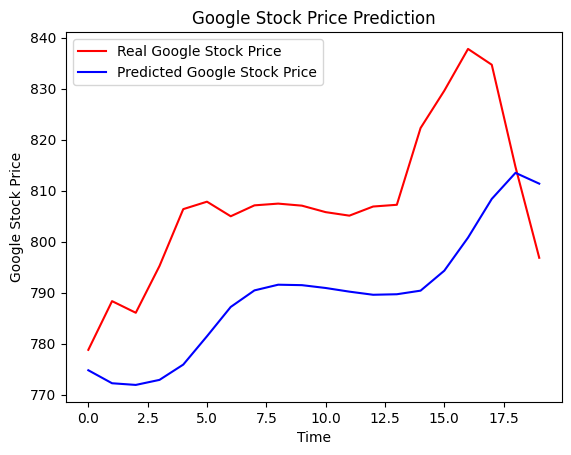

In [21]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Model cannot react to fast non-linear changes (ie. spikes). For parts with smooth changes, model works well.

[Note: for regression, RMSE is typically used to evaluate model performance. However, for Stock Price prediction, we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. The prediction could be close, but could take the opposite direction from the real stock price!!]